# Chapter 7 - Backpropagation Versus Perturbation Explainability

**Local Interpretable Model-agnostic Explanations (LIME)** is a perturbation-based XAI technique that provides local explainability by perturbing the training input, either partially occluding pixels in an image or substituting words in textual data to observe how they influence a model’s prediction. This notebook covers an example on how **LimeTextExplainer** explains a text classifier’s predictions based on the presence or absence of words based on Amazon Product Reviews dataset available at [Kaggle](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews). This sample notebook is tested with TensorFlow 2.10.1 and Python 3.9.10 using Amazon SageMaker Studio ml.m5.large general-purpose instance with 2 vCPU and 8 GiB. Here is the [link](https://aws.amazon.com/sagemaker/pricing/) regarding instance pricing reference. Alternatively, you can try this on your choice of IDE.

## Install and Load Libraries

In [2]:
# Install essential libraries

!pip install lime nltk wordcloud

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lime
import tensorflow as tf
from tensorflow import keras
from platform import python_version
import os
import warnings

warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Validate dependencies
print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

%matplotlib inline

TensorFlow version: 2.11.0
Python version: 3.9.10


## Prepare Data

Load and prepare the dataset. We will use the Text and Score columns for this example.

In [4]:
# Load the dataset and view unique target labels

df = pd.read_csv('reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# Filter feature and target columns

df = df[['Text','Score']]
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [6]:
# There are five classes for target labels in this dataset

df['Score'].unique()

array([5, 1, 4, 2, 3])

In [7]:
# Drop rows with missing values

df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    568454 non-null  object
 1   Score   568454 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [8]:
# Subsamples 3000 reviews for demo purpose. You can try to increase this number.

subsample_size = 3000  
df = df.sample(n=subsample_size, random_state=1)

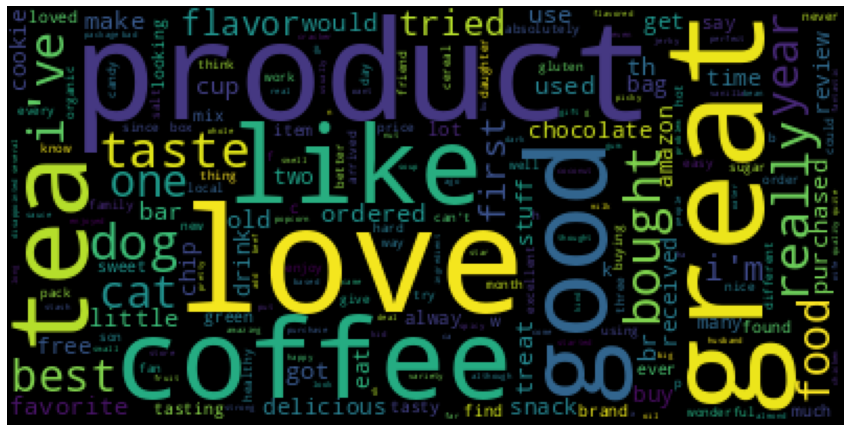

In [9]:
# Cleaning text and visualize wordcloud

from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s

df['clean_text'] = df['Text'].apply(clean_text)

text = df['clean_text'].to_string().lower() 

wordcloud = WordCloud(
    collocations = False,
    relative_scaling = 0.2,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('review_wordcloud.png', bbox_inches='tight')
plt.show()

In [10]:
# Assign model features and target column to variables

X = df['clean_text']
y = df['Score']

# Visualize labels' frequency distribution

y.value_counts()

5    1896
4     423
1     294
3     239
2     148
Name: Score, dtype: int64

In [11]:
# Fix a random seed for reproducibility

seed = 42 
np.random.seed(seed)

In [12]:
# Split the dataset for training and test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f'X_train count: {X_train.shape[0]}')
print(f'y_train count: {y_train.shape[0]}')
print(f'X_test count: {X_test.shape[0]}')
print(f'y_test count: {y_test.shape[0]}')

X_train count: 2400
y_train count: 2400
X_test count: 600
y_test count: 600


In [13]:
# Set a max number of unique words

vocab_size = 20000

# Set a max number of words to keep for each review
maxlen = 80  

In [14]:
# Tokenize and pad sequences

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

class Padder(BaseEstimator, TransformerMixin):
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

## Train Model

Create a Long-Short Term Memory(LSTM) recurrent neural network for text classification.

In [15]:
# Create a LSTM model

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 128
max_features = vocab_size + 1

import tensorflow as tf 
tf.random.set_seed(seed)

def create_model(max_features):
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Create a scikit-learn pipeline

pipeline = KerasClassifier(build_fn=create_model, epochs=10, batch_size=batch_size, max_features=max_features, verbose=1)

pipeline = make_pipeline(sequencer, padder, pipeline)

pipeline.fit(X_train, y_train)

Epoch 1/10
19/19 [==============================] - 10s 411ms/step - loss: 1.3492 - accuracy: 0.5958
Epoch 2/10
19/19 [==============================] - 8s 416ms/step - loss: 1.1001 - accuracy: 0.6321
Epoch 3/10
19/19 [==============================] - 8s 412ms/step - loss: 0.9700 - accuracy: 0.6375
Epoch 4/10
19/19 [==============================] - 8s 413ms/step - loss: 0.7713 - accuracy: 0.6871
Epoch 5/10
19/19 [==============================] - 8s 408ms/step - loss: 0.6539 - accuracy: 0.7396
Epoch 6/10
19/19 [==============================] - 8s 410ms/step - loss: 0.5556 - accuracy: 0.7596
Epoch 7/10
19/19 [==============================] - 8s 407ms/step - loss: 0.4633 - accuracy: 0.8067
Epoch 8/10
19/19 [==============================] - 8s 411ms/step - loss: 0.4088 - accuracy: 0.8333
Epoch 9/10
19/19 [==============================] - 8s 408ms/step - loss: 0.3350 - accuracy: 0.8583
Epoch 10/10
18/19 [===========================>..] - ETA: 0s - loss: 0.2690 - accuracy: 0.9028

## Evaluate Model

Obtain prediction and evaluate model's performance.

In [ ]:
# Compute predictions on test set

y_preds = pipeline.predict(X_test)

In [ ]:
# Evaluate model performance

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, ConfusionMatrixDisplay

print(f'Test Accuracy: {accuracy_score(y_test,y_preds)*100:.2f}%')
print(f'Classification Report:\n {classification_report(y_test, y_preds)}')

In [ ]:
# Create a confusion matrix

labels = [1,2,3,4,5]

cm = confusion_matrix(y_test, y_preds)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.savefig("confusion_matrix.png", bbox_inches='tight')

## Explain Text Classification

Compare predicted versus true class for a sample text review. Use LimeTextExplainer to explain the model's predictions based on the presence or absence of words.

In [ ]:
# Choose a test sample using different idx

idx = 599      # Correct predicted class
#idx = 125    # Incorrect predicted class
test_text = np.array(X_test)
test_class = np.array(y_test)
text_sample = test_text[idx]

class_names = [1,2,3,4,5]

#View the predicted probability for each target label in comparison to its true class

print(f'Sample Text:\n{text_sample}\n')
print(f'Probability: {pipeline.predict_proba([text_sample]).round(3)}')
print(f'True class: {class_names[test_class[idx]]}')

In [ ]:
## Instantiate a LimeTextExplainer and visualize the importance of words to the model's prediction

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(text=text_sample)

In [ ]:
# Remove important words. Use "|" to remove more than one word

text_sample_modified = re.sub('perfect|high|great|makes', ' ', text_sample)

# Evaluate the new predicted probability after removing the important words

print(f'Modified Sample Text:\n{text_sample_modified}\n')
print(f'Probability: {pipeline.predict_proba([text_sample_modified]).round(3)}')

We can see the predicted probability change after removing important words from the text. You can try a different sample text and swap out different words to evaluate the impact.